In [1]:
!pip install aif360

In [2]:
!pip install holisticai

In [3]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import histogram_plot
from holisticai.bias.plots import frequency_matrix_plot
from holisticai.bias.plots import frequency_plot

from aif360.sklearn.datasets import fetch_german
from aif360.sklearn.metrics import statistical_parity_difference
from aif360.sklearn.metrics import disparate_impact_ratio
from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.preprocessing import Reweighing

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
pip install 'aif360[OptimalTransport]'


##Lectura de los datos

In [4]:
#Cargamos los datos y los dividimos en conjuntos de entrada y salida

datos = fetch_german()
input = datos.X
output = datos.y

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
input.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'other_parties', 'residence_since',
       'property_magnitude', 'age', 'other_payment_plans', 'housing',
       'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'sex', 'marital_status'],
      dtype='object')

## Análisis de los datos

In [6]:
umbral_edad = []
for lista in input.index:
  umbral_edad.append(lista[1])

umbral_edad_array = np.array(umbral_edad)
np.unique(umbral_edad_array)

array(['aged', 'young'], dtype='<U5')

<Axes: >

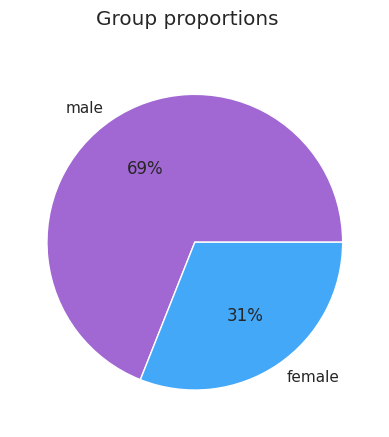

In [7]:
group_pie_plot(input['sex'])

<Axes: >

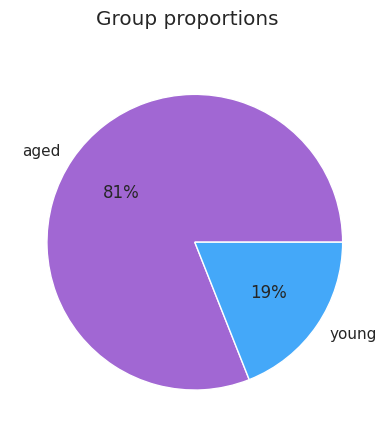

In [8]:
group_pie_plot(umbral_edad_array)

<Axes: >

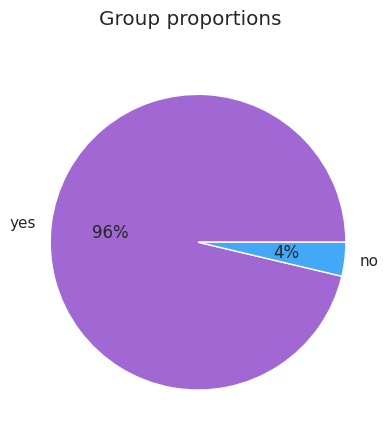

In [9]:
group_pie_plot(input['foreign_worker'])

<Axes: title={'center': 'Frequency matrix plot'}, xlabel='Class', ylabel='Group'>

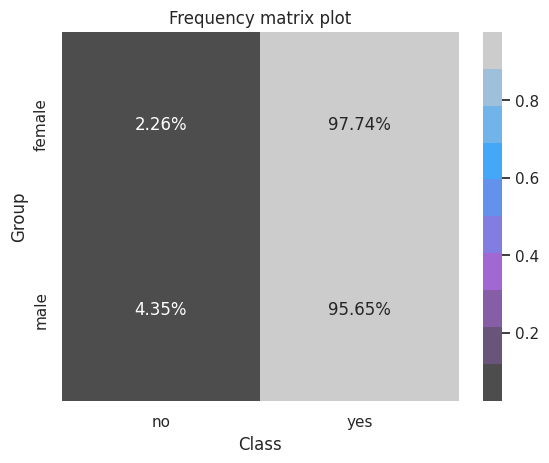

In [10]:
frequency_matrix_plot(input['sex'], input['foreign_worker'], normalize='group')

<Axes: title={'center': 'Frequency matrix plot'}, xlabel='Class', ylabel='Group'>

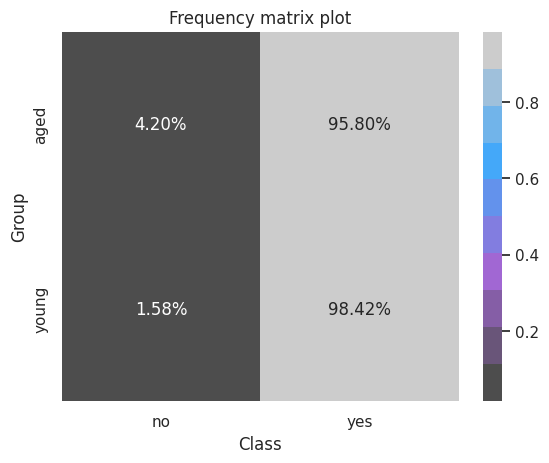

In [11]:
frequency_matrix_plot(umbral_edad_array, input['foreign_worker'], normalize='group')

## Procesado de datos

In [ ]:
#Codificamos los atributos protegidos

input.index = pd.MultiIndex.from_arrays(input.index.codes, names=input.index.names)
output.index = pd.MultiIndex.from_arrays(output.index.codes, names=output.index.names)

#Codificamos los valores de las columnas categoricas tanto en el input como en el output

le = LabelEncoder()
le2 = LabelEncoder()

for columna in input.columns:
  if input[columna].dtype != 'float64':
    input[columna] = le.fit_transform(input[columna])

output = pd.Series(le2.fit_transform(output), index=output.index)

#Dividimos los datos en datos de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Experimento 1 (asumimos que todas las clases son igual de importantes)



In [ ]:
modelo = RandomForestClassifier(random_state=42)
modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

precision1 = accuracy_score(y_test, y_pred) * 100
spd1_sexo = statistical_parity_difference(y_test, y_pred, prot_attr='sex')
spd1_age = statistical_parity_difference(y_test, y_pred, prot_attr='age')
spd1_foreign_worker = statistical_parity_difference(y_test, y_pred, prot_attr='foreign_worker')

dpr1_sexo = disparate_impact_ratio(y_test, y_pred, prot_attr='sex')
dpr1_age = disparate_impact_ratio(y_test, y_pred, prot_attr='age')
dpr1_foreign_worker = disparate_impact_ratio(y_test, y_pred, prot_attr='foreign_worker')

print("Precision del modelo: {:.2f}%".format(precision1))

print("Statistical Parity Difference sexo: {:.5f}".format(spd1_sexo))
print("Statistical Parity Difference edad: {:.5f}".format(spd1_age))
print("Statistical Parity Difference si es trabajador extranjero: {:.5f}".format(spd1_foreign_worker))

print("Disparate Impact Ratio sexo: {:.5f}".format(dpr1_sexo))
print("Disparate Impact Ratio edad: {:.5f}".format(dpr1_age))
print("Disparate Impact Ratio si es trabajador extranjero: {:.5f}".format(dpr1_foreign_worker))

Precision del modelo: 79.00%
Statistical Parity Difference sexo: -0.00198
Statistical Parity Difference edad: -0.21491
Statistical Parity Difference si es trabajador extranjero: 0.08784
Disparate Impact Ratio sexo: 0.99754
Disparate Impact Ratio edad: 0.74688
Disparate Impact Ratio si es trabajador extranjero: 1.10966


## Experimento 2 (reasignamos pesos con *sklearn*)



In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
pesos_pixeles = np.zeros(y_train.shape)
for i, tag in enumerate(y_train):
  if tag==0:
    pesos_pixeles[i] = class_weights[0]
  else:
    pesos_pixeles[i] = class_weights[1]

In [ ]:
model2 = RandomForestClassifier()
model2.fit(x_train, y_train, sample_weight=pesos_pixeles)

y_pred = model2.predict(x_test)

precision2 = accuracy_score(y_pred, y_test)*100

spd2_sexo = statistical_parity_difference(y_test, y_pred, prot_attr='sex')
spd2_age = statistical_parity_difference(y_test, y_pred, prot_attr='age')
spd2_foreign_worker = statistical_parity_difference(y_test, y_pred, prot_attr='foreign_worker')

dpr2_sexo = disparate_impact_ratio(y_test, y_pred, prot_attr='sex')
dpr2_age = disparate_impact_ratio(y_test, y_pred, prot_attr='age')
dpr2_foreign_worker = disparate_impact_ratio(y_test, y_pred, prot_attr='foreign_worker')

print("Model accuracy: {:.2f} %".format(precision2))
print("Statistical Parity Difference contando el sexo: {:.5f}".format(spd2_sexo))
print("Statistical Parity Difference contando la edad: {:.5f}".format(spd2_age))
print("Statistical Parity Difference si es trabajador extranjero: {:.5f}".format(spd2_foreign_worker))

print("Disparate Impact Ratio contando el sexo: {:.5f}".format(dpr2_sexo))
print("Disparate Impact Ratio contando la edad: {:.5f}".format(dpr2_age))
print("Disparate Impact Ratio contando si es trabajador extranjero: {:.5f}".format(dpr2_foreign_worker))

Model accuracy: 76.50 %
Statistical Parity Difference contando el sexo: 0.03472
Statistical Parity Difference contando la edad: -0.17948
Statistical Parity Difference si es trabajador extranjero: 0.15707
Disparate Impact Ratio contando el sexo: 1.04132
Disparate Impact Ratio contando la edad: 0.79761
Disparate Impact Ratio contando si es trabajador extranjero: 1.18634


## Experimento 3 (reasignamos pesos mediante preprocesamiento con *Reweighing*)



In [ ]:
rew = ReweighingMeta(estimator=RandomForestClassifier(),
                     reweigher=Reweighing())

params = {'estimator__n_estimators': [100, 300, 500, 700]}

model3 = GridSearchCV(estimator=rew, param_grid=params, scoring='accuracy')
model3.fit(x_train, y_train)

y_pred = model3.predict(x_test)

precision3 = accuracy_score(y_pred, y_test)*100

spd3_sexo = statistical_parity_difference(y_test, y_pred, prot_attr='sex')
spd3_age = statistical_parity_difference(y_test, y_pred, prot_attr='age')
spd3_foreign_worker = statistical_parity_difference(y_test, y_pred, prot_attr='foreign_worker')

dpr3_sexo = disparate_impact_ratio(y_test, y_pred, prot_attr='sex')
dpr3_age = disparate_impact_ratio(y_test, y_pred, prot_attr='age')
dpr3_foreign_worker = disparate_impact_ratio(y_test, y_pred, prot_attr='foreign_worker')

print("Model accuracy: {:.2f} %".format(precision3))
print("Statistical Parity Difference contando el sexo: {:.5f}".format(spd3_sexo))
print("Statistical Parity Difference contando la edad: {:.5f}".format(spd3_age))
print("Statistical Parity Difference contando si es trabajador extranjero: {:.5f}".format(spd3_foreign_worker))

print("Disparate Impact Ratio contando el sexo: {:.5f}".format(dpr3_sexo))
print("Disparate Impact Ratio contando la edad: {:.5f}".format(dpr3_age))
print("Disparate Impact Ratio contando si es trabajador extranjero: {:.5f}".format(dpr3_foreign_worker))

Model accuracy: 79.50 %
Statistical Parity Difference contando el sexo: -0.02579
Statistical Parity Difference contando la edad: -0.16690
Statistical Parity Difference contando si es trabajador extranjero: 0.05119
Disparate Impact Ratio contando el sexo: 0.96956
Disparate Impact Ratio contando la edad: 0.80909
Disparate Impact Ratio contando si es trabajador extranjero: 1.06111


In [ ]:
resultados_metricas = pd.DataFrame()

resultados_metricas['Experimento 1'] = [precision1, spd1_sexo, spd1_age, spd1_foreign_worker, dpr1_sexo, dpr1_age, dpr1_foreign_worker]
resultados_metricas['Experimento 2'] = [precision2, spd2_sexo, spd2_age, spd2_foreign_worker, dpr2_sexo, dpr2_age, dpr2_foreign_worker]
resultados_metricas['Experimento 3'] = [precision3, spd3_sexo, spd3_age, spd3_foreign_worker, dpr3_sexo, dpr3_age, dpr3_foreign_worker]

resultados_metricas.set_index(pd.Series(['Precision modelo (en %)',
                                         'Statistical Parity Difference sexo',
                                         'Statistical Parity Difference edad',
                                         'Statistical Parity Difference foreign worker',
                                         'Disparate Impact Ratio sexo',
                                         'Disparate Impact Ratio edad',
                                         'Disparate Impact Ratio foreign worker']), inplace=True)

resultados_metricas

,Experimento 1,Experimento 2,Experimento 3
Precision modelo (en %),79.000000,76.500000,79.500000
Statistical Parity Difference sexo,-0.001984,0.034722,-0.025794
Statistical Parity Difference edad,-0.214910,-0.179475,-0.166897
Statistical Parity Difference foreign worker,0.087842,0.157068,0.051193
Disparate Impact Ratio sexo,0.997537,1.041322,0.969555
Disparate Impact Ratio edad,0.746883,0.797613,0.809089
Disparate Impact Ratio foreign worker,1.109659,1.186335,1.061111
